In [1]:
try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0

import tensorflow as tf
import pandas as pd
import numpy as np
from keras import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.compat.v1.logging.set_verbosity(False)

# load data into a dataframe
data = pd.read_csv("./data/hr-formula-analytics-in-action.csv")
data.head()
# Example data used to create test and training sets:
# Employee_ID	Employees_Left	Avg_Employees	Engaged_Employees	Recruitment_Costs	Hires	Employees_Lacking_Skills	Gender	City	Job_Title	Department	Store_Location	Business_Unit	Division	Age	Length_of_Service	Absent_Hours	Performance_Rating	Education_Level	Training_Hours	Satisfaction_Score	Retention_Rate	Average_Employee_Tenure	Absenteeism_Rate	Diversity_Index	Turnover_Rate	Engagement_Score	Cost_Per_Hire	Skills_Gap_Percentage	Representation_Rate
# 5	100	80	5000	10	20	M	NY	Manager	HR	NY	BU1	D1	45	5	10	4	Bachelor's	30	75	0.95	4.8	0.00125	0.3	0.05	0.8	500	0.2	0.003157895
# 7	120	90	6000	12	30	F	LA	Analyst	Finance	LA	BU2	D2	30	3	5	3	Master's	20	80	0.941666667	4.793103448	0.000462963	0.241666667	0.058333333	0.75	500	0.25	0.002138643
# 6	110	85	5500	11	25	M	SF	Engineer	IT	SF	BU3	D3	35	4	8	5	High School	25	90	0.945454545	4.857142857	0.000855615	0.254545455	0.054545455	0.772727273	500	0.227272727	0.002447552
# 3	105	75	4800	9	15	F	NY	Specialist	Marketing	NY	BU1	D1	40	6	12	4	Associate's	15	70	0.971428571	4.888888889	0.00152381	0.257142857	0.028571429	0.714285714	533.3333333	0.142857143	0.002521008
# 4	95	70	4500	8	18	M	LA	Developer	IT	LA	BU3	D3	28	2	6	3	PhD	40	85	0.957894737	4.846153846	0.000902256	0.273684211	0.042105263	0.736842105	562.5	0.189473684	0.003007519

feats = ['Retention_Rate', 'Average_Employee_Tenure', 'Absenteeism_Rate', 
            'Diversity_Index', 'Turnover_Rate', 'Engagement_Score', 'Cost_Per_Hire', 
            'Skills_Gap_Percentage', 'Representation_Rate']

# Encode categorical features using LabelEncoder
categorical_features = ['Gender', 'City', 'Job_Title', 'Department', 'Store_Location', 
                        'Business_Unit', 'Division', 'Education_Level']

label_encoder = LabelEncoder()

for feature in categorical_features:
    data[feature] = label_encoder.fit_transform(data[feature])

# separate categorical and numerical features
numerical_features = data.select_dtypes(exclude=["object", "category"]).columns

# apply MinMaxScaler to numerical features
scaler = MinMaxScaler()
scaled_numerical_features = scaler.fit_transform(data[numerical_features])

# combine encoded categorical and scaled numerical features
encoded_data = np.concatenate([data[categorical_features].values, scaled_numerical_features], axis=1)

# split encoded data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(encoded_data, data[feats], test_size=0.3, random_state=42)

# define three different models to evaluate
models = [
    # model 1: simple multilayer perceptron
    Sequential([
        Dense(128, kernel_initializer='uniform', activation='relu', input_dim=x_train.shape[1]),
        Dense(64, kernel_initializer='uniform', activation='relu'),
        Dense(len(feats), kernel_initializer='uniform', activation='sigmoid')
    ], name='MLP'),

    # model 2: convolutional neural network (cnn)
    Sequential([
        Dense(128, kernel_initializer='uniform', activation='relu', input_dim=x_train.shape[1]),
        Dense(64, kernel_initializer='uniform', activation='relu'),
        Dense(32, kernel_initializer='uniform', activation='relu'),
        Dense(len(feats), kernel_initializer='uniform', activation='sigmoid')
    ], name='CNN'),

    # model 3: recurrent neural network (rnn) - long short-term memory (lstm)
    Sequential([
        LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)),
        LSTM(64),
        Dense(len(feats), activation='sigmoid')
    ], name='LSTM')
]

# evaluate and compare the performance of each model
for model in models:
    # compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    if model.name == 'LSTM':
        # convert x_train and x_test to tensorflow tensors with float32 dtype
        x_train_tensor = tf.convert_to_tensor(x_train, dtype=tf.float32)
        y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
        x_test_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)
        y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int64)

        model.fit(x_train_tensor, y_train, batch_size=32, epochs=10, verbose=1)

        # evaluate the model on the test set
        test_loss, test_acc = model.evaluate(x_test_tensor, y_test, verbose=0)
    else:
        model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1)

        # evaluate the model on the test set
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    
    # print the model's performance
    print(f"model: {model.name}")
    print(f"test loss: {test_loss:.4f}")
    print(f"test accuracy: {test_acc:.4f}")
    print("-----------------------------------")

print("3 Models Created and Tested")


Epoch 1/10
1/1 [==============================] - 1s 754ms/step - loss: 1148.4382 - accuracy: 0.6190
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 1141.9741 - accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 1135.1566 - accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 1127.8716 - accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 1119.7732 - accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 1110.5321 - accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 1099.9353 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 1087.8728 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 11ms/step - loss: 1074.1600 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 0s 8ms/step - loss: 1058.6904 - accuracy: 1.0000
model

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd

# Load your data
#df = pd.read_csv('your_data.csv')
df = pd.read_csv("./data/hr-formula-analytics-in-action.csv")

# List of categorical columns to convert
categorical_cols = ['Gender', 'City', 'Job_Title', 'Department', 'Store_Location', 'Business_Unit', 'Division', 'Education_Level']

# Convert categorical columns to numerical
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# List of columns to scale
scale_cols = ['Employees_Left', 'Avg_Employees', 'Engaged_Employees', 'Recruitment_Costs', 'Hires', 'Employees_Lacking_Skills', 'Age', 'Length_of_Service', 'Absent_Hours', 'Performance_Rating', 'Training_Hours', 'Satisfaction_Score', 'Retention_Rate', 'Average_Employee_Tenure', 'Absenteeism_Rate', 'Diversity_Index', 'Turnover_Rate', 'Engagement_Score', 'Cost_Per_Hire', 'Skills_Gap_Percentage', 'Representation_Rate']

# Scale the columns
scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

# Specify the number of clusters (k) you want to find
k = 3

# Perform K-Means clustering
#kmeans = KMeans(n_clusters=k)
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100)
labels = kmeans.fit_predict(df)
kmeans.fit(df)

# Get the cluster assignments for each data point
clusters = kmeans.predict(df)

# Add the cluster assignments to your original DataFrame
df['Cluster'] = clusters

print(df)

    Employee_ID  Employees_Left  Avg_Employees  Engaged_Employees  \
0             1        0.154074      -0.687219          -0.117492   
1             2        1.309631       2.344631           1.415016   
2             3        0.731853       0.828706           0.648762   
3             4       -1.001483       0.070743          -0.883746   
4             5       -0.423704      -1.445182          -1.650001   
5             6        1.887409       1.586668           2.181270   
6             7       -1.579261      -0.687219          -0.423994   
7             8        0.731853       0.828706           0.189009   
8             9        0.154074       0.070743           1.108514   
9            10       -1.001483      -0.990404          -0.883746   
10           11       -0.423704      -1.141997          -1.343499   
11           12        1.309631       1.131891           1.415016   
12           13        0.731853       0.525521           0.342260   
13           14       -0.423704   

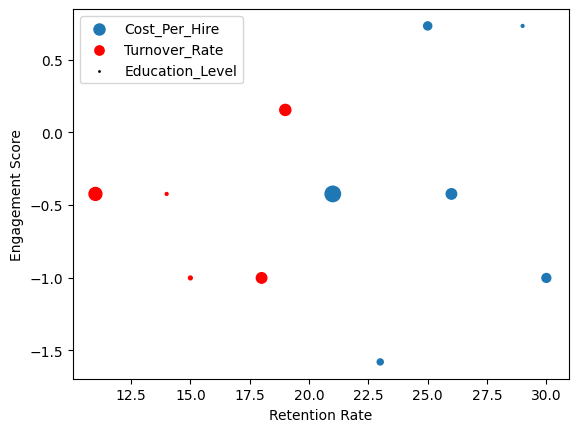

In [31]:
import matplotlib.pyplot as plt

# Assuming df is your original DataFrame
# Replace 'Size' with the actual numerical column you want to use
df['Size'] = df['Cost_Per_Hire']  # Replace 'Cost_Per_Hire' with the desired column

# Filter rows of original data for each cluster
filtered_label0['Size'] = df.loc[labels == 0, 'Cost_Per_Hire']
filtered_label2['Size'] = df.loc[labels == 2, 'Turnover_Rate']
filtered_label8['Size'] = df.loc[labels == 8, 'Education_Level']
filtered_label0 = df[labels == 0].copy().dropna(subset=['Size'])
filtered_label2 = df[labels == 2].copy().dropna(subset=['Size'])
filtered_label8 = df[labels == 8].copy().dropna(subset=['Size'])


# Remove any infinite or negative values
filtered_label0 = filtered_label0.replace([np.inf, -np.inf], np.nan).dropna(subset=['Size'])
filtered_label2 = filtered_label2.replace([np.inf, -np.inf], np.nan).dropna(subset=['Size'])
filtered_label8 = filtered_label8.replace([np.inf, -np.inf], np.nan).dropna(subset=['Size'])
filtered_label0 = filtered_label0[filtered_label0['Size'] >= 0]
filtered_label2 = filtered_label2[filtered_label2['Size'] >= 0]
filtered_label8 = filtered_label8[filtered_label8['Size'] >= 0]

# Plotting the results with marker size based on the 'Size' column
plt.scatter(filtered_label0.iloc[:, 0], filtered_label0.iloc[:, 1], label='Cost_Per_Hire', s=filtered_label0['Size']*50)
plt.scatter(filtered_label2.iloc[:, 0], filtered_label2.iloc[:, 1], label='Turnover_Rate', s=filtered_label2['Size']*50, color='red')
plt.scatter(filtered_label8.iloc[:, 0], filtered_label8.iloc[:, 1], label='Education_Level', s=filtered_label8['Size']*50, color='black')

# Customize the plot as needed
plt.xlabel('Retention Rate')
plt.ylabel('Engagement Score')
plt.legend()
plt.show()

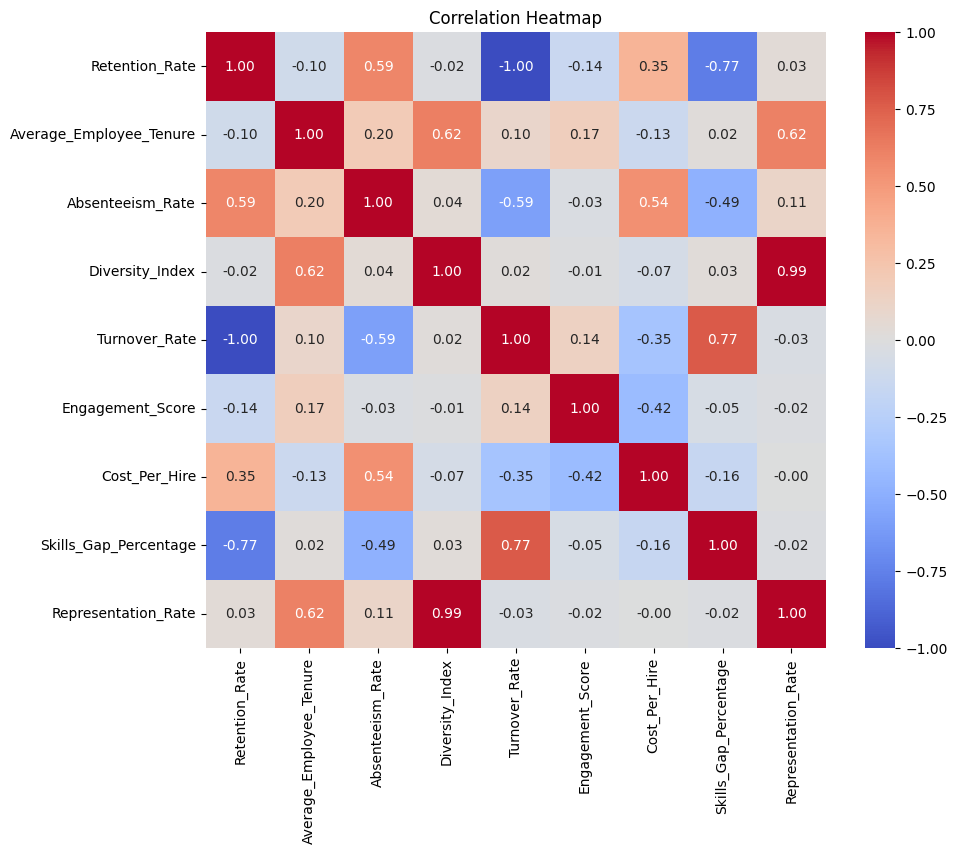

In [4]:
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = data[feats].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


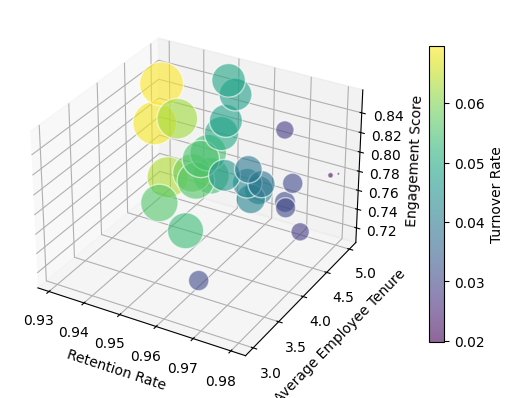

In [9]:
# from mpl.scatter import scatter_3d

# # Scatter plot with a bubble size representing a third dimension
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(data['Retention_Rate'], data['Average_Employee_Tenure'], data['Engagement_Score'],
#            s=data['Turnover_Rate']*100, alpha=0.6, edgecolors="w", cmap="viridis")

# ax.set_xlabel('Retention Rate')
# ax.set_ylabel('Average Employee Tenure')
# ax.set_zlabel('Engagement Score')
# ax.set_title('Bubble Chart for Three-Dimensional Data')
# plt.show()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a figure
fig = plt.figure()

# Add a subplot with 3D projection
ax = fig.add_subplot(111, projection='3d')

# Sample data (replace with your actual data)
x = data['Retention_Rate']
y = data['Average_Employee_Tenure']
z = data['Engagement_Score']

# Bubble size (replace with your actual data)
bubble_size = data['Turnover_Rate']

# Normalize bubble_size to be in the range [0, 1] for better visibility
normalized_bubble_size = (bubble_size - min(bubble_size)) / (max(bubble_size) - min(bubble_size))

# Plot the data with bubble size
sc = ax.scatter(x, y, z, s=normalized_bubble_size * 1000, c=bubble_size, alpha=0.6, edgecolors="w", cmap="viridis")

# Set axis labels
ax.set_xlabel('Retention Rate')
ax.set_ylabel('Average Employee Tenure')
ax.set_zlabel('Engagement Score')

# Add a colorbar
cbar = fig.colorbar(sc, ax=ax, pad=0.1, shrink=0.8)
cbar.set_label('Turnover Rate')

# Show the plot
plt.show()

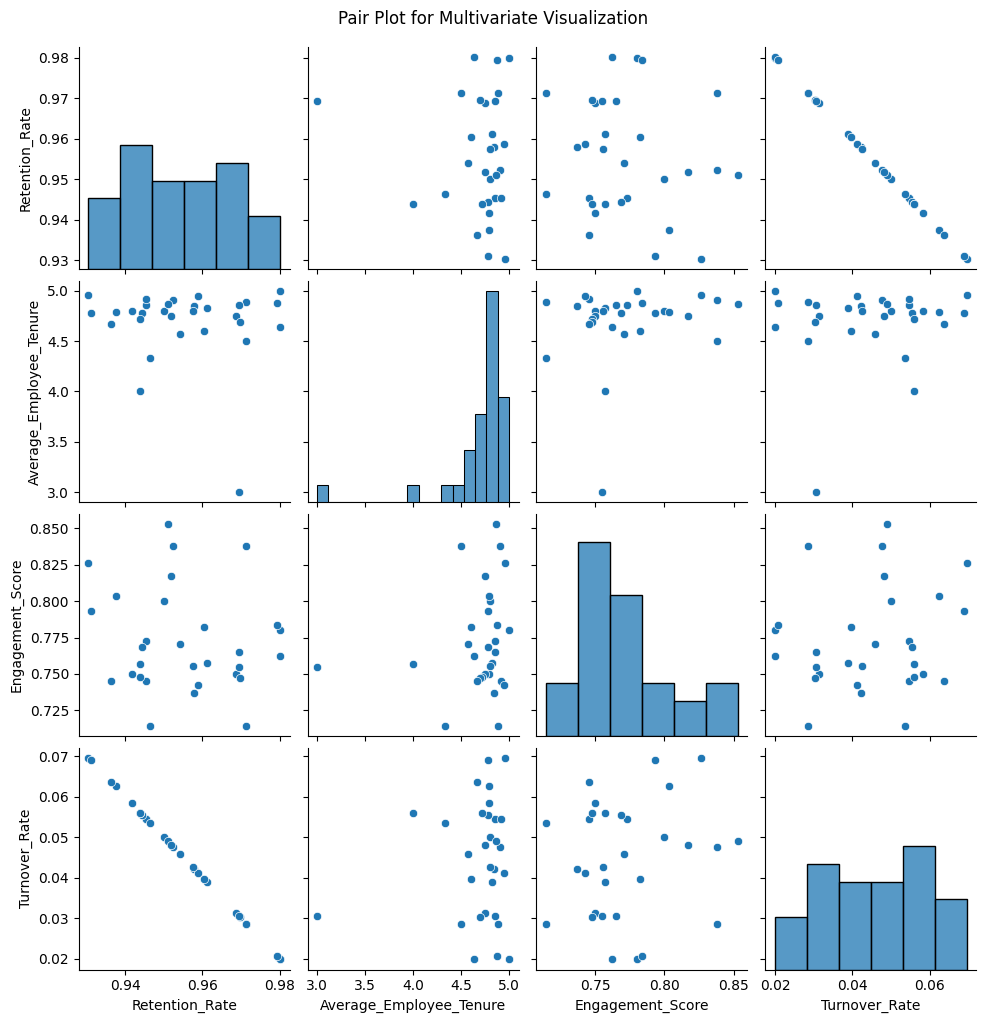

In [8]:
# Create a pair plot for selected features
selected_features = ['Retention_Rate', 'Average_Employee_Tenure', 'Engagement_Score', 'Turnover_Rate']
sns.pairplot(data[selected_features], height=2.5)
plt.suptitle('Pair Plot for Multivariate Visualization', y=1.02)
plt.show()